# Churn Predition - Sparkify Project
This project build a classification model to predict user churn analysing user activities on a music streaming app called Sparkify.

The project is build using Pyspark and pass through the steps below:

- Load data to SparkSession
- Clean and Preprocess Data
- Exploratory Data Analysis - EDA
- Feature Selection
- Model building and optimization
- Model evalution

The analysis is initialy done on a tiny subset (128MB) of the full dataset available (12GB). 

Once the initial analysis is done, the full pipeline with all the dataset (12GB) is processed on AWS EMR Spark Cluster. 

In [1]:
import datetime
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, lag
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import countDistinct
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.window import Window

import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

import re


In [2]:
#!pip install seaborn==0.9.1

In [3]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkifly Project") \
    .getOrCreate()

In [4]:
spark.version

'2.4.3'

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. 

In [5]:
#event_data = "s3n://udacity-dsnd/sparkify/sparkify_event_data.json"

file = 'mini_sparkify_event_data.json'
df = spark.read.json(file)

In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
print('total number of rows:' , df.count())

total number of rows: 286500


In [8]:
df.head(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

In [9]:
# clean rows with empty userId
df = df.filter("userId <> ''")

In [10]:
# number of distinct users
n_users = df.select("userId").distinct().count()

print("number of distinct users: ", n_users)

number of distinct users:  225


# Exploratory Data Analysis

In [11]:
# type of subscription
df.select("level").distinct().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [12]:
# type of page that user visit
df.select("page").distinct().show(truncate=False)

+-------------------------+
|page                     |
+-------------------------+
|Cancel                   |
|Submit Downgrade         |
|Thumbs Down              |
|Home                     |
|Downgrade                |
|Roll Advert              |
|Logout                   |
|Save Settings            |
|Cancellation Confirmation|
|About                    |
|Settings                 |
|Add to Playlist          |
|Add Friend               |
|NextSong                 |
|Thumbs Up                |
|Help                     |
|Upgrade                  |
|Error                    |
|Submit Upgrade           |
+-------------------------+



In [13]:
df.filter("userId = '100010'").select(["userId", "page", "artist"]).sort(["ts"]).show()

+------+-----------+--------------------+
|userId|       page|              artist|
+------+-----------+--------------------+
|100010|   NextSong|Sleeping With Sirens|
|100010|   NextSong|Francesca Battist...|
|100010|   NextSong|              Brutha|
|100010|  Thumbs Up|                null|
|100010|   NextSong|         Josh Ritter|
|100010|   NextSong|               LMFAO|
|100010|   NextSong|         OneRepublic|
|100010|   NextSong|       Dwight Yoakam|
|100010|Roll Advert|                null|
|100010|   NextSong|      The Chordettes|
|100010|   NextSong|Coko featuring Ki...|
|100010|   NextSong|            The Cure|
|100010|Roll Advert|                null|
|100010|   NextSong|Kid Cudi Vs Crookers|
|100010|  Thumbs Up|                null|
|100010|   NextSong|            Yeasayer|
|100010|   NextSong|             Ben Lee|
|100010|Roll Advert|                null|
|100010|   NextSong|  ? & The Mysterians|
|100010|Roll Advert|                null|
+------+-----------+--------------

In [14]:
# user location
print('number of disctinct locations: ',
      df.select('location').distinct().count())

number of disctinct locations:  114


### Define Churn

A column `Churned` is created to identify users that has churned. 
`Cancellation Confirmation` events is used to define churn, which happen for both paid and free users.

In [15]:
# define user churn
hasCancelled = udf(lambda x: 1 if x=='Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn('Churn', hasCancelled(df['page']))

user_window = Window.partitionBy('userId')
df = df.withColumn('Churned', F.max('Churn').over(user_window))

#### calculate churn rate

In [16]:
n_user_churn = df.select(['userId']).filter("Churn=1").distinct().count()

print("total users: ", n_users)
print("users churned: ",n_user_churn)
print("users not churned: ", (n_users - n_user_churn) )
print("churn rate: ", n_user_churn/n_users )


total users:  225
users churned:  52
users not churned:  173
churn rate:  0.2311111111111111


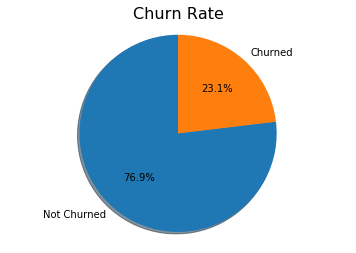

In [17]:
# Pie chart
labels = 'Not Churned', 'Churned'
sizes = [(n_users - n_user_churn), n_user_churn]


fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Churn Rate', loc='center', fontsize=16);
plt.show();

### Explore Data
Once defined churn, we perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. 

#### info about the artists

In [18]:
artist_no_churned = np.array(df.filter('artist is not null and Churned=0').select('artist').collect())
artist_no_churned = set(artist_no_churned.flatten())

artist_churned = np.array(df.filter('artist is not null and Churned=1').select('artist').collect())
artist_churned = set(artist_churned.flatten())

artist_only_churn = artist_churned - artist_no_churned
artist_only_no_churn = artist_no_churned - artist_churned

print('distinct artist: ',
      '17655')
      #df.filter('artist is not null').select('artist').distinct().count())

print('distinct artist in churned users: ',
      len(artist_churned))

print('distinct artist not churned users: ',
      len(artist_no_churned))

print('artist only in churned: ', 
      len(artist_churned - artist_no_churned))

print('artist only in not churned: ',
     len(artist_no_churned - artist_churned))

#df = df.withColumn('artist_only_churn', col('artist').isin(artist_only_churn).cast('integer'))
#df = df.withColumn('artist_only_no_churn', col('artist').isin(artist_only_no_churn).cast('integer')) 

distinct artist:  17655
distinct artist in churned users:  8402
distinct artist not churned users:  16652
artist only in churned:  1003
artist only in not churned:  9253


Users in group that has not churned listen songs from more distinct artists. Feature 'artist' will be included in the model.

## Feature Engineering

New features are created based on the original dataset 

In [19]:
# create new column to count the number of songs played by the user
is_song = udf(lambda x: 1 if x=='NextSong' else 0, IntegerType())
df = df.withColumn('NextSong', is_song(df['page']))

In [20]:
# create new column to check if user has been in paid subscription
has_paid= udf(lambda x: 1 if x=='paid' else 0, IntegerType()) 
df = df.withColumn('hasPaid', has_paid('level'))

In [21]:
# create new column to check if user has downgrade
has_downgrade =  udf(lambda x: 1 if x=='Downgrade' else 0, IntegerType()) 
df = df.withColumn('hasDowngrade', has_downgrade('page'))

#### general info aggregated by userId

In [22]:
# general info aggregated by userId
user = df.groupBy("userId").agg(
    F.max('location').alias('max_location'),
    F.max('gender').alias('max_gender'),
    F.max('hasPaid').alias('max_hasPaid'),
    F.max('hasDowngrade').alias('max_hasDowngrade'),
    F.max('Churn').alias('max_churn'),
    F.countDistinct('artist').alias('dist_artist')
#    F.collect_list("artist").alias("artist_list")
)

#user.show(5)

#### time between user sessions

In [23]:
# time between sessions

# rank in session
session_by_ts_win = Window.partitionBy(['userId','sessionId']).orderBy('ts')
df = df.withColumn('rank', F.rank().over(session_by_ts_win))

# time_diff
user_by_ts = Window.partitionBy(['userId']).orderBy('ts')
df = df.withColumn('ts_diff', col('ts') - F.lag('ts',1).over(user_by_ts))

# time diff between first page in current session - last page in previous session
time_btw_session = df.select(['userId','ts_diff'])\
                         .filter("rank=1 and ts_diff is not null")\
                         .groupBy('userId').agg(avg('ts_diff').alias('time_btw_sessions'))
#time_btw_session.show()

#### number of songs played, and number os sessions aggregated BY user, session


In [24]:
# number of songs played, and number os sessions
song_session = df.groupBy(['userId','sessionId'])\
                .agg(
                    F.sum('length'), 
                    F.sum('NextSong')\
                )\
                .groupBy('userId')\
                .agg(
                    F.avg('sum(length)').alias("avg_session_length"),
                    F.avg('sum(NextSong)').alias("avg_session_songs"),
                    F.sum('sum(length)').alias("total_session_length"),   
                    F.sum('sum(NextSong)').alias("total_songs_played"),
                    F.count('sum(length)').alias("total_sessions")
                )

#song_session.show()

#### join dataframes with aggregated columns

This step joins 3 different dataframes that needed to be computed in separated steps:
- data aggregated at the user level
- data aggreated at the user and session level
- time between session

In [25]:
joined_df = None
joined_df = user.join(song_session, ["userId"], "inner")\
                .join(time_btw_session, ["userId"], "inner")

### Persist processed dataframe and save to local file or Amazon S3
To this point, all the preprecessing steps has been concluded. (cleaning, aggregation)

Aggregated data will be stored to the local file system, or remote stored like Amazon S3.

Thosee steps save computation time and resources, as all the followings steps (analysis, modelling) is done on aggregated info.

In [26]:
user2 = joined_df.persist()

In [27]:
user2.write.mode("overwrite").parquet("joined_df2.parquet")

In [28]:
user2.count()

210

#### Analyse statistics using pandas

The original small dataset has 286,500 rows. But after aggregating the original dataset to the userId level, we reduced the dataset to 210 rows.

The full dataset has 26,259,199 rows. After aggregating, reduced to 22,278 rows.

After aggregation, the analysis could be done using either spark dataframe or pandas dataframe. The following analysis is done using pandas dataframe as it easier to calculate stats. 

In [29]:
user_pd = user2.toPandas()

#### Numerical features

For numerical features, we compare the mean on users that has churned vs mean on users that has not churned. Features with more difference between those groups are good predictors.

In [30]:
# calculate mean for users in group not_churned and churned
user_pd['avg_session_length'] = user_pd['avg_session_length']/(60*60)
user_pd['total_session_length'] = user_pd['total_session_length']/(60*60)
user_pd['time_btw_sessions'] = user_pd['time_btw_sessions']/(60*60*24*1000)

In [31]:
user_pd.groupby('max_churn')['max_hasPaid','max_hasDowngrade'].mean()

,max_hasPaid,max_hasDowngrade
max_churn,,
0,0.768293,0.719512
1,0.760870,0.739130


In [32]:
user_pd.groupby('max_churn')['dist_artist', 'avg_session_length',
       'avg_session_songs', 'total_session_length', 'total_songs_played',
       'total_sessions', 'time_btw_sessions'].mean()

,dist_artist,avg_session_length,avg_session_songs,total_session_length,total_songs_played,total_sessions,time_btw_sessions
max_churn,,,,,,,
0,786.993902,5.036803,70.911949,80.635538,1164.829268,15.506098,6.026682
1,581.456522,4.618036,64.868798,54.302568,786.173913,11.152174,2.894424


In [64]:
#plt.figure(figsize=(12,8))
#ax = sns.scatterplot(data=user_pd, x="time_btw_sessions", y="total_songs_played", hue="max_churn")
#ax.set_title('Time between sessions on each group', loc='center', fontsize=16);

**Features with LOW difference on mean between not_churned and churned groups:**
- max_hasPaid, max_hasDowngrade 

The stats show that users that at some point has paid or has downgrade do not make much diference on churn.

Those features will NOT be used for modelling.

**Features with HIGH difference on mean between not_churned and churned groups:**
- dist_artist, 
- avg_session_length, 
- avg_session_songs, 
- total_session_length, 
- total_songs_played, 
- total_sessions, 
- time_btw_sessions

Those features will be used for modelling

Churned users tend to stay less time in each session and listen less songs according to (avg_session_length,	avg_session_songs)

Oddly, churned users tend connect more frequently than not churned users according to (time_btw_sessions)

#### Categoricals features

Analysis of user gender.

In [34]:
tab = pd.crosstab(user_pd['max_gender'], user_pd['max_churn'])
tab.apply(lambda x: x/x.sum(), axis=1)

max_churn,0,1
max_gender,,
F,0.806122,0.193878
M,0.758929,0.241071


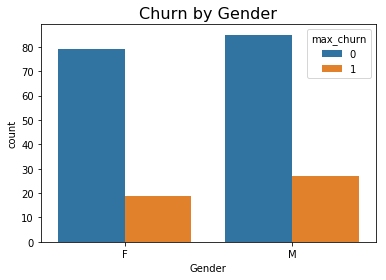

In [35]:
ax = sns.countplot(x='max_gender', hue="max_churn", data=user_pd)
ax.set_title('Churn by Gender', loc='center', fontsize=16);
ax.set_xlabel("Gender");

Churn rate seems to be higher for Males (24%) than Females (19%), so feature will be used for modelling

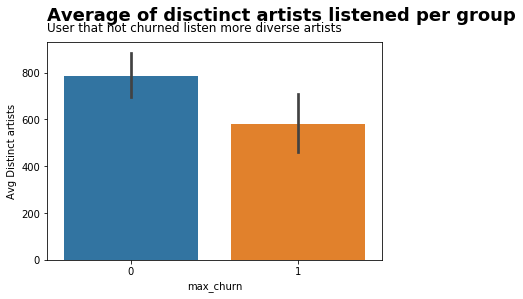

In [36]:
ax = sns.barplot(y="dist_artist", x="max_churn", data=user_pd, estimator=np.mean)
#ax.set_title('Average of disctinct artists listen per group', loc='center', fontsize=16);
#ax.set_xlabel("Churn");
plt.text(x=0, y=1.1, s="Average of disctinct artists listened per group", fontsize=18, weight='bold', transform=ax.transAxes);
plt.text(x=0, y=1.05, s= "User that not churned listen more diverse artists", fontsize=12, transform=ax.transAxes);
ax.set_ylabel("Avg Distinct artists");

# Modeling

- Split the full dataset into train and test
- Test out several of the machine learning (LogisticRegression, RandomForest, LinearSVC)
- Evaluate the performance of various models, tuning parameters as necessary. 
- Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.
- Determine your winning model based on testset

In [37]:
# loading cleaned and aggregated data
df2 = spark.read.parquet("joined_df2.parquet")

In [38]:
# define label colum
df2 = df2.withColumnRenamed('max_churn','label')

df2.printSchema()

root
 |-- userId: string (nullable = true)
 |-- max_location: string (nullable = true)
 |-- max_gender: string (nullable = true)
 |-- max_hasPaid: integer (nullable = true)
 |-- max_hasDowngrade: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- dist_artist: long (nullable = true)
 |-- avg_session_length: double (nullable = true)
 |-- avg_session_songs: double (nullable = true)
 |-- total_session_length: double (nullable = true)
 |-- total_songs_played: long (nullable = true)
 |-- total_sessions: long (nullable = true)
 |-- time_btw_sessions: double (nullable = true)



#### Split data into validation and test set

- validation set is used for crossvalidation e gridsearch
- test set is used to evaluate the model perfomance on 'unseen' data

In [39]:
# split data into validation and test set
validation, test = df2.randomSplit([0.9, 0.1], seed=52)

#### define functions to model training and model evaluation

In [40]:
def fit_model(model, paramGrid):
    """
    Build a pipeline and fit a model using CrossValidator and hyperparam optimization.
    Numerical features are Scaled with StandardScaler
    Categorical feature gender is transformed with StringIndexer
    
    Args:
    model (spark.ml.classification): The classifier algorithm
    paramGrid (ParamGridBuilder): A grid of hyperparameters used to optimize the model
    
    return:
    fitted_model: A cross validated fitted model
    
    """
    
    #cv = CountVectorizer(inputCol="artist_list", outputCol="TF")
    #location_index = StringIndexer(inputCol='max_location', outputCol="location_index", handleInvalid='skip')

    gender_index = StringIndexer(inputCol='max_gender', outputCol="gender_index", handleInvalid='keep')

    #scaler
    #"max_hasDowngrade","max_hasPaid",
    numerical = ["dist_artist", "avg_session_length",
                 "avg_session_songs","total_session_length","total_songs_played",
                 "total_sessions","time_btw_sessions"]

    numfeatures = VectorAssembler(inputCols=numerical, outputCol='NumFeatures')
    scaler = StandardScaler(inputCol='NumFeatures', outputCol="ScaledNumFeatures")

    assembler = VectorAssembler(inputCols=[#"TF",
                                           #"location_index",
                                           "gender_index",
                                           "ScaledNumFeatures"
                                          ], 
                                outputCol='features')

    pipeline = Pipeline(stages=[gender_index,
                                numfeatures, 
                                scaler, 
                                assembler,
                                model])

    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                              numFolds=3)
        
    fitted_model = crossval.fit(validation)
    
    return fitted_model

In [41]:
def evaluate_results(results):
    """
    Evaluate the predited values VS real values
    
    Returns:
    score (float): F1-Score
    """
    score1 = MulticlassClassificationEvaluator(metricName='f1').evaluate(results)
    return score1

In [69]:
def print_grid_metrics(avgMetrics, paramGrid):
    params_fmt = []
    for params in paramGrid:
        params_list = [(a.name, b) for a,b in params.items()]
        
        params_fmt.append(params_list)
   
    df = pd.DataFrame(data={'params': params_fmt, 'f1-score': avgMetrics})

    return df    

### Hyperparameters tunning

For each family of algorithm (LogisticRegression, RandomForestClassifier and LinearSVC), two iterations of GridParams is applied. 

The first iteration include the default params and a broad range of values.

After analysing the results of the first iterations, the second iteration is done with a narrow range of values.

A third iteration it done if the metrics are not converging.

In [43]:
list_features = ["gender_index","dist_artist", "avg_session_length",
                 "avg_session_songs","total_session_length","total_songs_played",
                 "total_sessions","time_btw_sessions"]

#### Logistic Regression

In [44]:
############################
# Logistic Regression
############################
lr=  LogisticRegression(elasticNetParam=0)

In [71]:
# search space
lr_grid = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.01, 0.1]) \
    .addGrid(lr.maxIter,[50,100]) \
    .build()

In [72]:
lr_model = fit_model(lr, lr_grid)
print_grid_metrics(lr_model.avgMetrics, lr_grid)

,params,f1-score
0,"[(regParam, 0.0), (maxIter, 50)]",0.867940
1,"[(regParam, 0.0), (maxIter, 100)]",0.870518
2,"[(regParam, 0.01), (maxIter, 50)]",0.819959
3,"[(regParam, 0.01), (maxIter, 100)]",0.819959
4,"[(regParam, 0.1), (maxIter, 50)]",0.686715
5,"[(regParam, 0.1), (maxIter, 100)]",0.686715


Increasing the hyperparameter maxIter from 50 to 100 did not change metrics, so the next iterations it done closer to 50.

The range of regParam is better when close to zero, so a new search is done closer to zero

In [47]:
lr_grid = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.001, 0.005]) \
    .addGrid(lr.maxIter,[10,25, 50]) \
    .build()

lr_model = fit_model(lr, lr_grid)
print_grid_metrics(lr_model.avgMetrics, lr_grid)

,params,score
0,"[(regParam, 0.0), (maxIter, 10)]",0.868032
1,"[(regParam, 0.0), (maxIter, 25)]",0.862452
2,"[(regParam, 0.0), (maxIter, 50)]",0.867940
3,"[(regParam, 0.001), (maxIter, 10)]",0.861063
4,"[(regParam, 0.001), (maxIter, 25)]",0.872678
5,"[(regParam, 0.001), (maxIter, 50)]",0.867149
6,"[(regParam, 0.005), (maxIter, 10)]",0.828047
7,"[(regParam, 0.005), (maxIter, 25)]",0.843037
8,"[(regParam, 0.005), (maxIter, 50)]",0.843037


#### With the second iteration, values have converged near 0.87.  So,  will pick the best params, which is this case is 
[(regParam, 0.001), (maxIter, 25)]	0.8726.  

There was very few improvement compared to the default algorithms params [(regParam, 0.0), (maxIter, 100)]	0.8705

In [67]:
score = evaluate_results(lr_model.transform(test))
print('Logistic Regression f1-score: ', score)

Logistic Regression f1-score:  0.8888888888888888


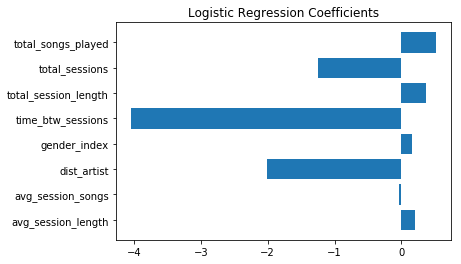

In [49]:
lr_corr = lr_model.bestModel.stages[-1].coefficients
plt.barh(list_features,lr_corr)
plt.xticks(rotation='horizontal')
plt.title('Logistic Regression Coefficients')
plt.show()

#### RandomForest

In [50]:
##########################
# RandomForestClassifier
##########################
rf = RandomForestClassifier(seed=42)

In [74]:
# first iteration
rf_grid = ParamGridBuilder() \
    .addGrid(rf.maxDepth,[5,10,20])\
    .addGrid(rf.numTrees,[10,20])\
    .build()

In [75]:
rf_model = fit_model(rf, rf_grid)
print_grid_metrics(rf_model.avgMetrics, rf_grid)

,params,f1-score
0,"[(maxDepth, 5), (numTrees, 10)]",0.818369
1,"[(maxDepth, 5), (numTrees, 20)]",0.804428
2,"[(maxDepth, 10), (numTrees, 10)]",0.797212
3,"[(maxDepth, 10), (numTrees, 20)]",0.799264
4,"[(maxDepth, 20), (numTrees, 10)]",0.792837
5,"[(maxDepth, 20), (numTrees, 20)]",0.799264


Results were quite stable at the first iterations, a new iteration with different params for numTrees is executed to make conclusions

In [76]:
# second iteration
rf_grid = ParamGridBuilder() \
    .addGrid(rf.maxDepth,[5,10,20])\
    .addGrid(rf.numTrees,[15,30,40])\
    .build()

In [77]:
rf_model = fit_model(rf, rf_grid)
print_grid_metrics(rf_model.avgMetrics, rf_grid)

,params,f1-score
0,"[(maxDepth, 5), (numTrees, 15)]",0.817277
1,"[(maxDepth, 5), (numTrees, 30)]",0.835312
2,"[(maxDepth, 5), (numTrees, 40)]",0.821908
3,"[(maxDepth, 10), (numTrees, 15)]",0.828263
4,"[(maxDepth, 10), (numTrees, 30)]",0.838208
5,"[(maxDepth, 10), (numTrees, 40)]",0.838434
6,"[(maxDepth, 20), (numTrees, 15)]",0.832950
7,"[(maxDepth, 20), (numTrees, 30)]",0.843168
8,"[(maxDepth, 20), (numTrees, 40)]",0.838434


Best performance is achieved with [(maxDepth, 20), (numTrees, 30)] 0.8431

There was a few improvement over the defaults params [(maxDepth, 5), (numTrees, 20)]	0.8044

In [66]:
score = evaluate_results(rf_model.transform(test))
print('RandomForest f1-score: ', score)

RandomForest f1-score:  0.8395061728395061


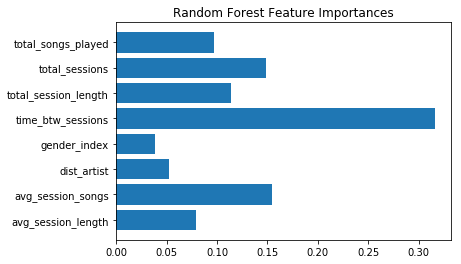

In [56]:
# Extract feature importance
featImportances = np.array(rf_model.bestModel.stages[-1].featureImportances)
plt.barh(list_features,featImportances)
plt.xticks(rotation='horizontal')
plt.title('Random Forest Feature Importances')
plt.show()

#### LinearSVC

In [57]:
############
# LinearSVC
############
lsvc = LinearSVC()

In [78]:
lsvc_grid = ParamGridBuilder() \
    .addGrid(lsvc.maxIter,[50, 100])\
    .addGrid(lsvc.regParam,[0.0, 0.01, 0.1])\
    .build()

In [79]:
lsvc_model = fit_model(lsvc, lsvc_grid)
print_grid_metrics(lsvc_model.avgMetrics, lsvc_grid)

,params,f1-score
0,"[(maxIter, 50), (regParam, 0.0)]",0.751216
1,"[(maxIter, 50), (regParam, 0.01)]",0.731359
2,"[(maxIter, 50), (regParam, 0.1)]",0.686715
3,"[(maxIter, 100), (regParam, 0.0)]",0.787855
4,"[(maxIter, 100), (regParam, 0.01)]",0.743615
5,"[(maxIter, 100), (regParam, 0.1)]",0.686715


Best performance was achieved when regParam is 0. So a new iteration is done with values closer to zero.

MaxIter was better with 100, so values closer to 100 will be used

In [80]:
lsvc_grid = ParamGridBuilder() \
    .addGrid(lsvc.maxIter,[100,120])\
    .addGrid(lsvc.regParam,[0.0, 0.001, 0.005])\
    .build()

In [81]:
lsvc_model = fit_model(lsvc, lsvc_grid)
print_grid_metrics(lsvc_model.avgMetrics, lsvc_grid)

,params,f1-score
0,"[(maxIter, 100), (regParam, 0.0)]",0.787855
1,"[(maxIter, 100), (regParam, 0.001)]",0.802269
2,"[(maxIter, 100), (regParam, 0.005)]",0.784024
3,"[(maxIter, 120), (regParam, 0.0)]",0.799260
4,"[(maxIter, 120), (regParam, 0.001)]",0.830649
5,"[(maxIter, 120), (regParam, 0.005)]",0.802269


Best performance whas found with params [(maxIter, 120), (regParam, 0.001)]	0.8306

There was a considerable improvement compared to default params [(maxIter, 100), (regParam, 0.0)]	0.7878

In [82]:
score = evaluate_results(lsvc_model.transform(test))
print('Linear SVC f1-score: ', score)

Linear SVC f1-score:  0.8243021346469623


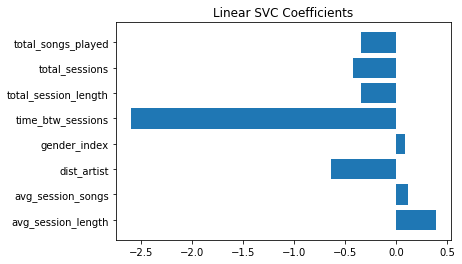

In [63]:
lr_corr = lsvc_model.bestModel.stages[-1].coefficients
plt.barh(list_features,lr_corr)
plt.xticks(rotation='horizontal')
plt.title('Linear SVC Coefficients')
plt.show()